In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set_style('darkgrid')

# Kernel function

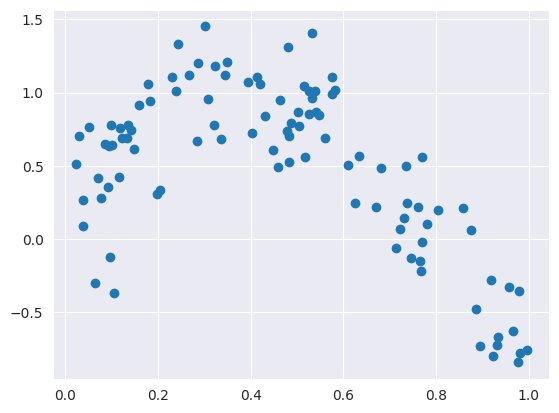

In [ ]:
x = scipy.stats.uniform.rvs(size=100)
x = np.sort(x)
eps = scipy.stats.norm.rvs(loc = 0,scale = 1/3,size=100)
y = np.sin(4*x) + eps
plt.scatter(x,y)
plt.show()

In [22]:
def knn_kernel(X,x0, k=30):
    val = 1/2/np.sort(np.abs(X-x0))[k]
    t = np.zeros(len(X))
    t[np.argsort(np.abs(X-x0))[:k]] = val
    return t

def epanechnikov_kernel(X,x0,lambda_=0.2):
    t = np.abs(X-x0)/ lambda_
    return (abs(t)<=1) * 0.75 * (1-t**2)

def tricube_kernel(X,x0, lambda_ = 0.2):
    t = np.abs(X-x0)/ lambda_
    return (abs(t)<=1) * (1-abs(t)**3)**3

def nadaraya_watson_kernel_avg(X,y,x0,kernel):
    return sum(kernel(X,x0)*y) / sum(kernel(X,x0))


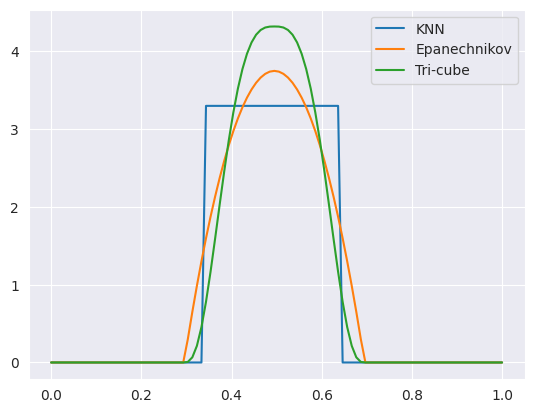

In [23]:
from scipy.integrate import quad

xx = np.linspace(0,1,100)
yy = np.sin(4*xx)

plt.plot(xx,knn_kernel(xx,xx[49]),label='KNN')
plt.plot(xx, epanechnikov_kernel(xx,xx[49])/quad(epanechnikov_kernel, 0, 1, args=(xx[49], 0.2))[0],label = 'Epanechnikov')
plt.plot(xx, tricube_kernel(xx,xx[49])/quad(tricube_kernel, 0, 1, args=(xx[49], 0.2))[0],label = 'Tri-cube')
plt.legend()
plt.show()

# Nadaraya-Watson kernel-weighted average

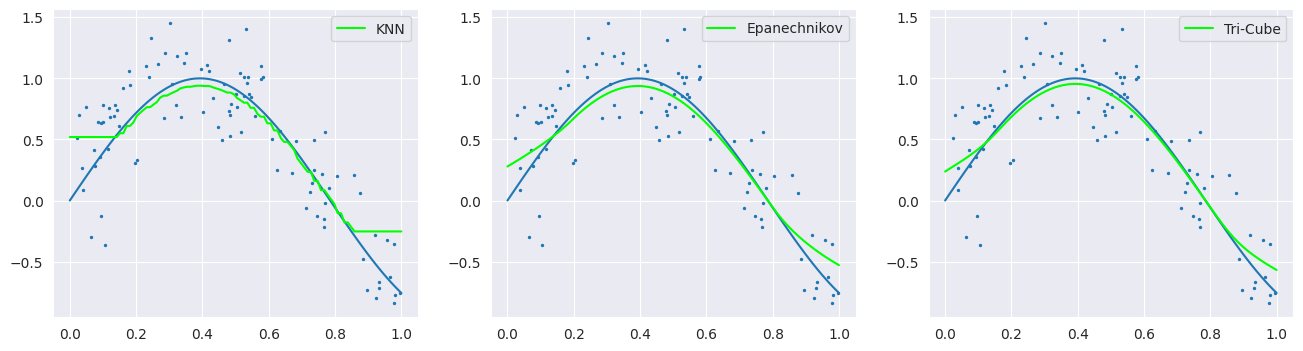

In [ ]:
xx = np.linspace(0,1,100)
yy = np.sin(4*xx)

y_knn, y_epane, y_tri = np.zeros(100), np.zeros(100), np.zeros(100)

for i in range(100):
    y_knn[i] = nadaraya_watson_kernel_avg(xx,yy,xx[i], knn_kernel)
    y_epane[i] = nadaraya_watson_kernel_avg(xx,yy,xx[i], epanechnikov_kernel)
    y_tri[i] = nadaraya_watson_kernel_avg(xx,yy,xx[i], tricube_kernel)


plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(xx, yy)
plt.scatter(x, y, s=2)
plt.plot(xx,y_knn, label='KNN',color='#00FF00')
plt.legend()

plt.subplot(132)
plt.plot(xx, yy)
plt.scatter(x, y, s=2)
plt.plot(xx,y_epane, label = 'Epanechnikov',color='#00FF00')
plt.legend()

plt.subplot(133)
plt.plot(xx, yy)
plt.scatter(x, y, s=2)
plt.plot(xx,y_tri, label='Tri-Cube',color='#00FF00')
plt.legend()
plt.show()

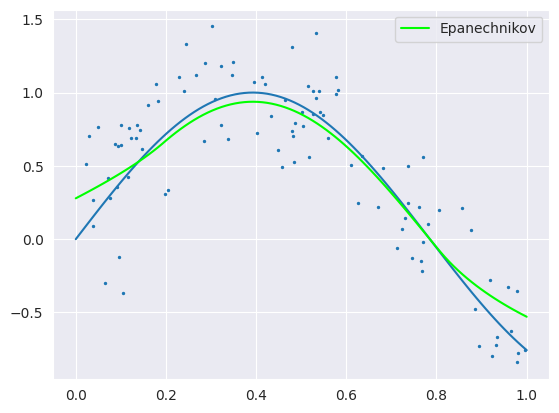

In [ ]:
plt.plot(xx, yy)
plt.scatter(x, y, s=2)
plt.plot(xx,y_epane, label = 'Epanechnikov',color='#00FF00')
plt.legend()
plt.show()

# Local Linear Regrssion

$ \hat{f}(x_0) = b(x_0)^T (\mathbf{B}^T\mathbf{W}(x_0)\mathbf{B})^{-1}\mathbf{X}^T\mathbf{W}(x_0)\mathbf{y}$

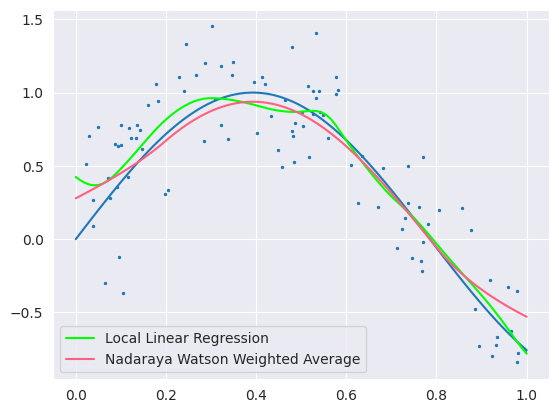

In [ ]:
B = np.hstack((np.ones(100).reshape(-1,1),x[:,np.newaxis]))
fitted_vals = np.zeros(100)

for i in range(100):
    x0 = xx[i]
    b = np.hstack((1,x0))
    Wx0 = np.diag(tricube_kernel(xx,x0))
    S = b.T @ np.linalg.inv(B.T @ Wx0 @ B) @ B.T @ Wx0
    # S[S<0] = 0
    # S /= np.sum(S)
    fitted_vals[i] =  S @ y

plt.plot(xx, yy)
plt.scatter(x, y, s=2)
plt.plot(xx,fitted_vals, label='Local Linear Regression',color='#00FF00')
plt.plot(xx,y_epane, label = 'Nadaraya Watson Weighted Average',color='#FF607F')
plt.legend()
plt.show()

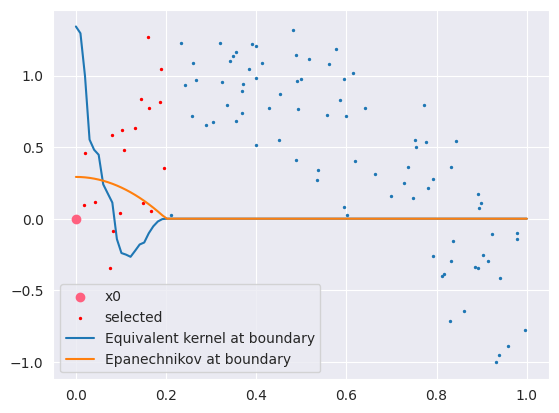

In [ ]:
x0 = xx[0]
b = np.hstack((1,x0))
Wx0 = np.diag(tricube_kernel(xx,x0))
S =  b.T @ np.linalg.inv(B.T @ Wx0 @ B) @ B.T @ Wx0
selected_idx = (np.abs(x-x0)/ 0.2 <= 1)
no_selected_idx = (np.abs(x-x0)/ 0.2 > 1)

plt.scatter(xx[0],yy[0],label='x0',color='#FF607F')
plt.scatter(x[selected_idx], y[selected_idx],s=2,color='red',label='selected')
plt.scatter(x[no_selected_idx], y[no_selected_idx],s=2)
plt.plot(xx,S*4, label="Equivalent kernel at boundary")
plt.plot(xx,epanechnikov_kernel(xx,xx[0])/sum(epanechnikov_kernel(xx,xx[0]))*4, label="Epanechnikov at boundary")
plt.legend()
plt.show()

## LOOCV

$CV(\hat{f}_{\lambda}) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{f}^{-i}(x_i))^2 = \frac{1}{N}\sum_{i=1}^N \left( \frac{y_i - \hat{f}(x_i)}{1-S_{\lambda_{ii}}}\right)^2$

In [ ]:
lambda_ = np.linspace(0.1,1,5)
err = np.zeros(5)
for idx,l in enumerate(lambda_):
    for i in range(100):
        x0 = xx[i]
        b = np.hstack((1,x0))
        Wx0 = np.diag(tricube_kernel(xx,x0, lambda_=l))
        S = B @ np.linalg.inv(B.T @ Wx0 @ B) @ B.T @ Wx0
        fitted_vals =  b.T @ np.linalg.inv(B.T @ Wx0 @ B) @ B.T @ Wx0 @ y
        err[idx] += ((y[i] - fitted_vals) / (1-S[i,i]))**2

    err[idx] /= 100

err

array([0.14918005, 0.12908083, 0.13804571, 0.15443486, 0.17760794])

# Structured Local Regression in $\mathbb{R}^p$

In [24]:
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from sklearn.base import BaseEstimator, TransformerMixin

class LocalRegression(BaseEstimator):
    def __init__(self, model, kernel_size = 1):
        self.model = model
        self.kernel_size = kernel_size

    def fit(self,X, y):
        self.X, self.y = X, y
        return self

    def predict_proba(self, X):
        return self.__predict(X, self.model.predict_proba)

    def predict(self, X):
        return self.__predict(X, self.model.predict)

    def __predict(self, X, fnc):
        result = []

        for i in range(X.shape[0]):
            self.model.fit(self.X, self.y, sample_weight=self.tri_cube_kernel_with_NN_window(X[i:i + 1, :]))

            result.append(np.atleast_2d(fnc([X[i]])))

        return np.vstack(result)

    def tri_cube_kernel_with_NN_window(self, x0):
        points_cnt = self.kernel_size

        if points_cnt <= 1: # then input will be fraction
            points_cnt = int(self.X.shape[0] * points_cnt)

        distances = cdist(self.X, x0)
        kernel_points_indices = np.argpartition(distances, points_cnt, axis=0)[:points_cnt]
        max_distance = np.max(distances[kernel_points_indices])

        t = distances/max_distance
        result = (t <= 1)*(1-t**3)**3
        return np.squeeze(result)

In [ ]:
file_dir_ozone = ""
ozone = pd.read_csv(file_dir_ozone,sep='\t')
ozone.describe()

,ozone,radiation,temperature,wind
count,111.000000,111.000000,111.000000,111.000000
mean,42.099099,184.801802,77.792793,9.938739
std,33.275969,91.152302,9.529969,3.559218
min,1.000000,7.000000,57.000000,2.300000
25%,18.000000,113.500000,71.000000,7.400000
50%,31.000000,207.000000,79.000000,9.700000
75%,62.000000,255.500000,84.500000,11.500000
max,168.000000,334.000000,97.000000,20.700000


## Conditional Model

In [ ]:
features = ['radiation', 'temperature', 'wind']
X, y = ozone[features].values, ozone['ozone'].values
y = y**(1/3)

In [ ]:
temp_min, temp_max = 57, 97
wind_min, wind_max = 2.3, 20.7
temp_bins = [(57, 76.5), (68.2, 81), (76, 86), (80.7, 97)]
wind_bins = [(2.3, 9.25), (6.8, 10.25), (9.15, 12.5), (10.25, 20.7)]

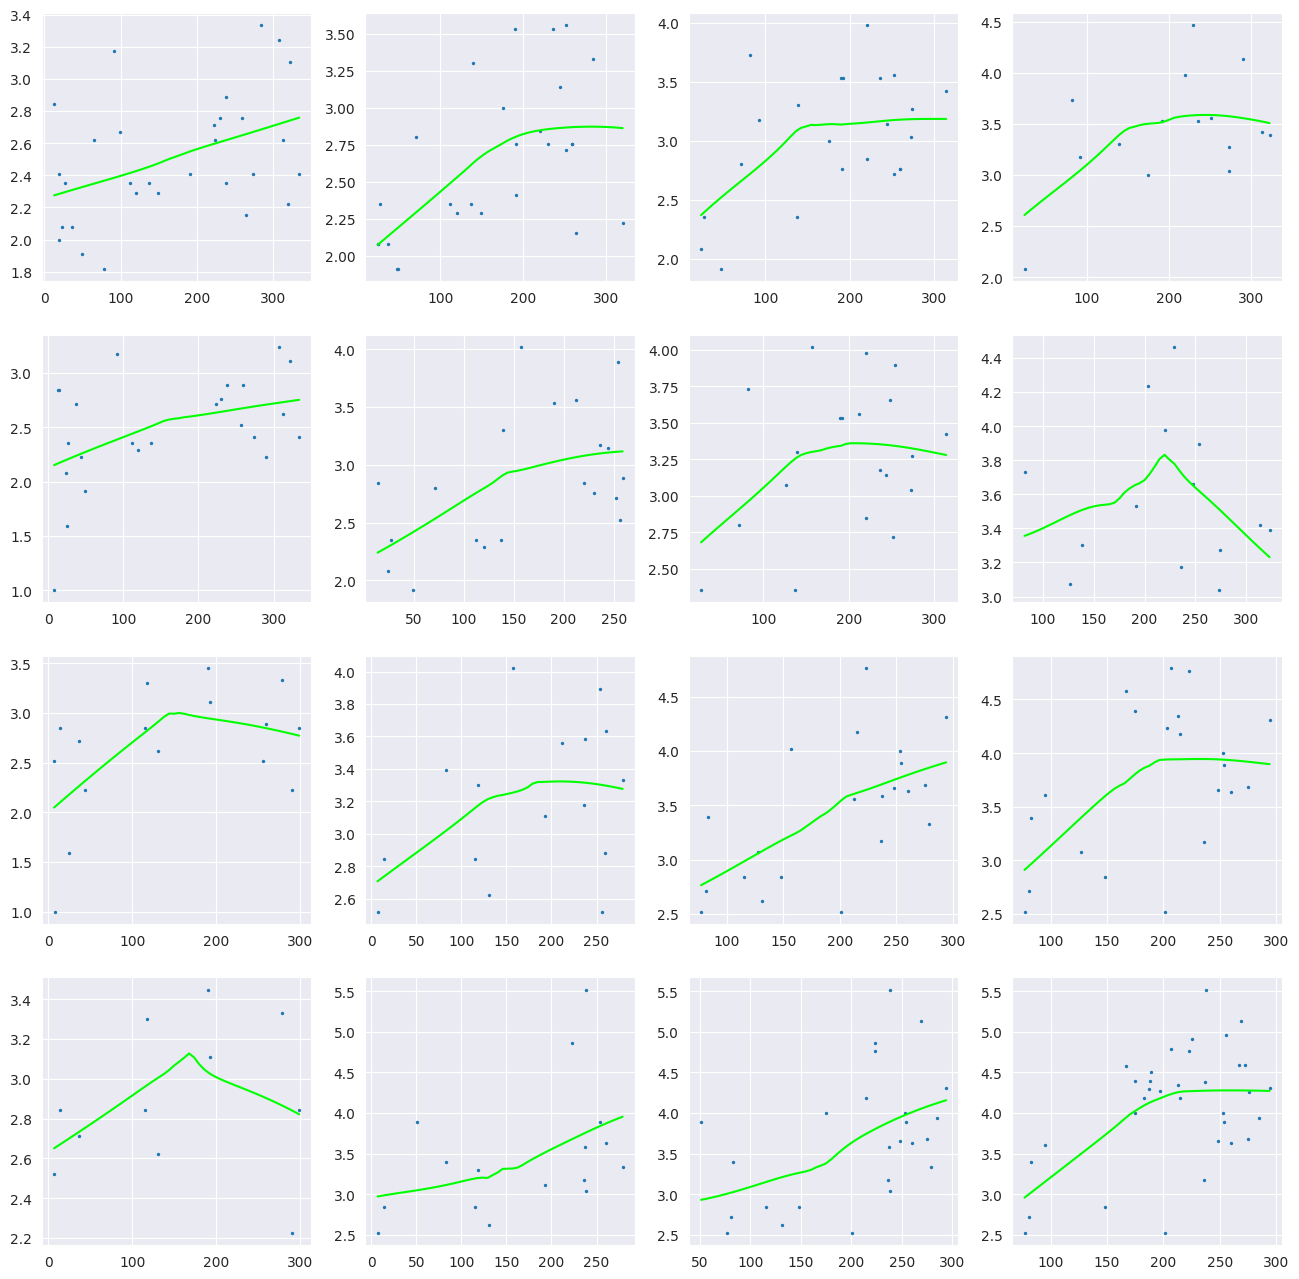

In [ ]:
from sklearn.linear_model import LinearRegression
import itertools

def calc_regression_plot(X, y):
    X = X[:, :1] # radiation
    xx = np.linspace(np.min(X), np.max(X), 50)
    yy = LocalRegression(model=LinearRegression(), kernel_size=0.9).fit(X, y).predict(np.atleast_2d(xx).T)
    return xx, yy

plt.figure(figsize=(16,16))

for i, j in itertools.product(range(4), range(4)):
    temp_from, temp_to, wind_from, wind_to = *temp_bins[j], *wind_bins[3 - i]
    in_temp_bin = (temp_from <= X[:, 1]) & (X[:, 1] <= temp_to)
    in_wind_bin = (wind_from <= X[:, 2]) & (X[:, 2] <= wind_to)
    in_bin = in_temp_bin & in_wind_bin
    X_in_bin, y_in_bin = X[in_bin, :], y[in_bin]
    xx, yy = calc_regression_plot(X_in_bin, y_in_bin)

    plt.subplot(4,4,i*4 + j+1)
    plt.scatter(X_in_bin[:,0], y_in_bin, s=2)
    plt.plot(xx,yy,color='#00FF00')

plt.show()

# Locally weighted Logistic Regression

In [ ]:
file_dir_sad = ""
df = pd.read_csv(file_dir_sad)
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
df.head()

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,True,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,False,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,True,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,True,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,True,60,25.99,57.34,49,1


In [26]:
X = df['sbp'].values.astype(float)
X_c = np.hstack([np.ones(len(X)).reshape(-1,1),X.reshape(-1,1)])
y = df['chd'].values.reshape(-1,1)

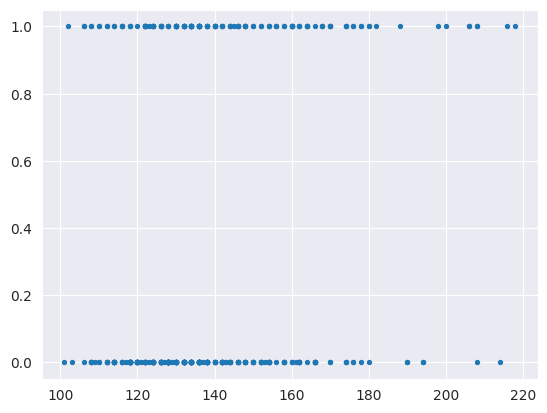

In [27]:
plt.scatter(X,y, s=8)
plt.show()

## first, naive logistic regression: 'chd' ~ 'sbp'

In [28]:
beta = np.zeros((2,1))
def sigmoid(h):
    return 1/(1+np.exp(-h))

for i in range(10):
    p = sigmoid(X_c @ beta)
    W = np.diag(np.ravel(p*(1-p)))
    beta += np.linalg.inv(X_c.T @ W @ X_c) @ X_c.T @ (y-p)

beta

array([[-3.3527161 ],
       [ 0.01950936]])

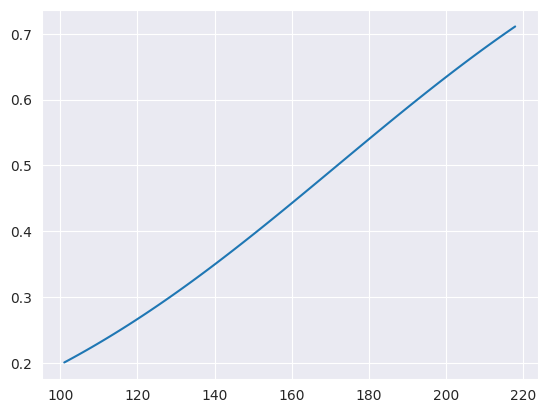

In [77]:
from sklearn.linear_model import LogisticRegression
xx = np.linspace(np.min(X), np.max(X), 100)
xx_c = np.hstack([np.ones(len(xx)).reshape(-1,1),xx.reshape(-1,1)])
reg = LogisticRegression()

reg.fit(X_c,y)
fitted_naive = reg.predict_proba(xx_c)[:,1]
plt.plot(xx, fitted_naive)
plt.show()

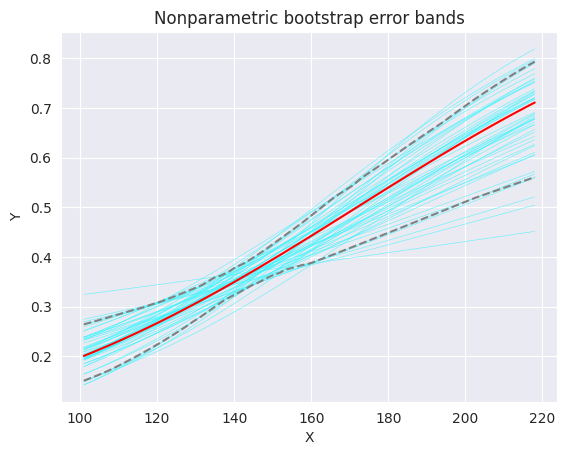

In [78]:
from sklearn.utils import resample

import warnings

warnings.filterwarnings('ignore')

yy_preds = np.zeros((len(xx), 50))


for b in range(50):
    X_re, Y_re = resample(X_c,y)
    reg.fit(X_re, Y_re)

    yy_pred_re = reg.predict_proba(xx_c)[:,1]
    yy_preds[:,b] = yy_pred_re.reshape(-1,)
    plt.plot(xx, yy_pred_re, color='#36f5ff', linewidth = 0.4, alpha=0.8)


plt.plot(xx, np.sort(yy_preds,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds,axis=1)[:,-4], '--', color='gray')
plt.plot(xx, fitted_naive, color='red')
plt.xlabel('X')
plt.ylabel("Y")
plt.title("Nonparametric bootstrap error bands")
plt.show()

Note that $\hat{\beta} \sim \mathcal{N}(\beta, (X^TWX)^{-1})$

## now, locally weighted case

In [51]:
def sigmoid(h):
    return np.ravel(1/(1+np.exp(-h)))

def tricube_1d(X,x0,frac=0.65):
    dists = abs(X-x0)
    cut = int(len(X)*frac)
    idxs = np.argpartition(dists,cut,axis=0)[:cut]
    lambda_ = np.max(dists[idxs])
    t = dists / lambda_
    res = (t<=1)*(1-t**3)**3
    return np.squeeze(res)

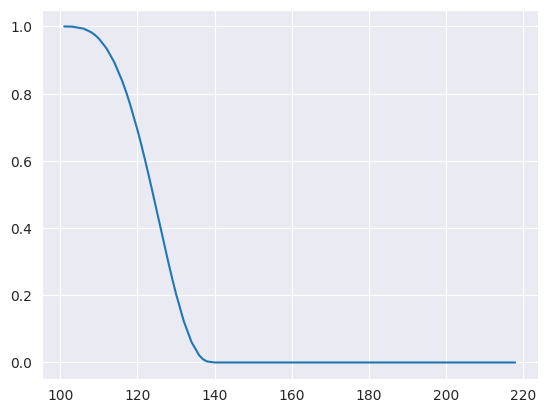

In [52]:
X_sorted = np.sort(X)
plt.plot(X_sorted,tricube_1d(X_sorted,xx[0]))
plt.show()

In [53]:
weight = np.diag(tricube_1d(X,xx[i]))
p = sigmoid(X_c@beta)
W = np.diag(p*(1-p)*tricube_1d(X,xx[i]))
grad = X_c.T @ (tricube_1d(X,xx[i]).reshape(-1,1)*(y-p.reshape(-1,1)))
hessian = X_c.T @ W @ X_c
grad.shape

(2, 1)

In [61]:
fitted = np.zeros(len(xx_c))
se = np.zeros(len(xx_c))

for i in range(len(xx_c)):
    beta = np.zeros((2,1))
    grad = np.ones((2,1)) * np.inf

    while np.linalg.norm(grad) > 1e-6:
        weight = np.diag(tricube_1d(X,xx[i]))
        p = sigmoid(X_c@beta)
        W = np.diag(p*(1-p)*tricube_1d(X,xx[i]))
        grad = (weight@X_c).T @ (y-p.reshape(-1,1))
        hessian = X_c.T @ W @ X_c
        beta += np.linalg.inv(hessian) @ grad


    fitted[i] = xx_c[i]@beta

    W_nonWeighted = np.diag(p*(1-p))
    A = np.linalg.inv(hessian) @ (weight@X_c).T
    V = A @ W_nonWeighted @ A.T
    se[i] = np.sqrt(xx_c[i].T @ V @ xx_c[i])


sigmoid(fitted)

array([0.32503624, 0.31932696, 0.3139312 , 0.30886126, 0.30413698,
       0.29977598, 0.29576091, 0.29205517, 0.28862338, 0.28541836,
       0.28236497, 0.27937487, 0.27635642, 0.27325087, 0.2700042 ,
       0.26658745, 0.26321591, 0.2605055 , 0.26202689, 0.26322527,
       0.26599916, 0.27103775, 0.27786315, 0.28495095, 0.29194272,
       0.29829459, 0.3041275 , 0.30914204, 0.31634685, 0.32404356,
       0.33165077, 0.33794699, 0.34457241, 0.34687738, 0.34830427,
       0.35154999, 0.3553301 , 0.36031259, 0.36667331, 0.37167071,
       0.37743296, 0.38352714, 0.39056169, 0.39807701, 0.4037959 ,
       0.41156412, 0.41944707, 0.42769806, 0.43637345, 0.44536704,
       0.45458337, 0.46335959, 0.47104857, 0.47711452, 0.48183396,
       0.48585458, 0.48968536, 0.49375826, 0.4984977 , 0.50400684,
       0.5101653 , 0.51653087, 0.52292671, 0.52941039, 0.53600555,
       0.54270014, 0.54946877, 0.5562822 , 0.56311314, 0.56993755,
       0.57673459, 0.58348635, 0.59017854, 0.59679975, 0.60334

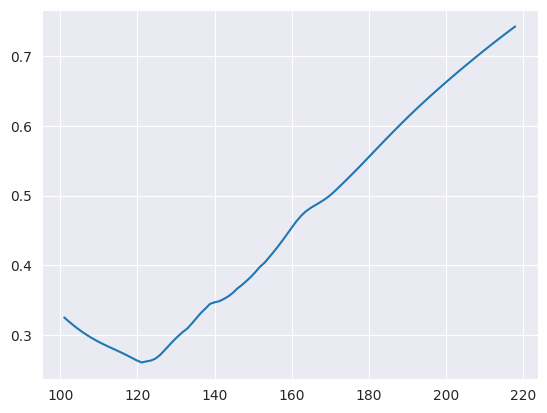

In [62]:
plt.plot(xx,sigmoid(fitted))
plt.show()

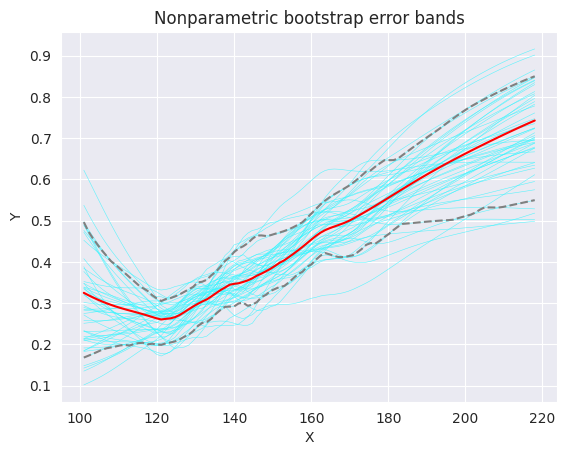

In [63]:
yy_preds = np.zeros((len(xx), 50))

for b in range(50):
    X_re, y_re = resample(X,y)
    X_c_re = np.hstack([np.ones(len(X_re)).reshape(-1,1),X_re.reshape(-1,1)])

    fitted_re = np.zeros(len(xx_c))

    for i in range(len(xx_c)):
        beta = np.zeros((2,1))
        grad = np.ones((2,1)) * np.inf

        while np.linalg.norm(grad) > 1e-6:
            weight = np.diag(tricube_1d(X_re,xx[i]))
            p = sigmoid(X_c_re @ beta)
            W = np.diag(p*(1-p)*tricube_1d(X_re,xx[i]))
            grad = (weight@X_c_re).T @ (y_re-p.reshape(-1,1))
            hessian = X_c_re.T @ W @ X_c_re
            beta += np.linalg.inv(hessian) @ grad

        fitted_re[i] = xx_c[i]@beta

    yy_pred_re = sigmoid(fitted_re)
    yy_preds[:,b] = yy_pred_re.reshape(-1,)
    plt.plot(xx, yy_pred_re, color='#36f5ff', linewidth = 0.4, alpha=0.8)

plt.plot(xx, np.sort(yy_preds,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds,axis=1)[:,-4], '--', color='gray')
plt.plot(xx, sigmoid(fitted), color='red')

plt.xlabel('X')
plt.ylabel("Y")
plt.title("Nonparametric bootstrap error bands")
plt.show()

In [65]:
yy_preds_local = yy_preds
y_pres_local = sigmoid(fitted)

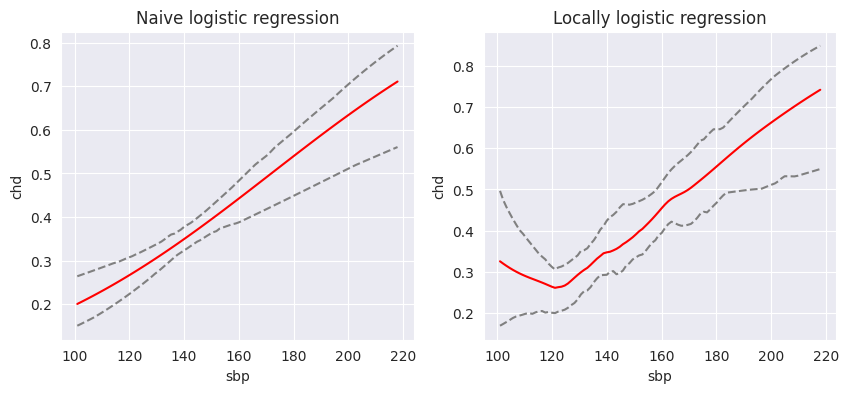

In [80]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(xx, np.sort(yy_preds,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds,axis=1)[:,-4], '--', color='gray')
plt.plot(xx, fitted_naive, color='red')
plt.xlabel('sbp')
plt.ylabel("chd")
plt.title("Naive logistic regression")

plt.subplot(122)
plt.plot(xx, np.sort(yy_preds_local,axis=1)[:,4], '--', color='gray')
plt.plot(xx, np.sort(yy_preds_local,axis=1)[:,-4], '--', color='gray')
plt.plot(xx, y_pres_local, color='red')

plt.xlabel('sbp')
plt.ylabel("chd")
plt.title("Locally logistic regression")
plt.show()